In [ ]:
# Copyright 2026 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - JAX OWL-ViT v2

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fcommunity%2Fmodel_garden%2Fmodel_garden_jax_owl_vit_v2.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_jax_owl_vit_v2.ipynb">
      <img alt="GitHub logo" src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px"><br> View on GitHub
    </a>
  </td>
</tr></tbody></table>

## Overview

This notebook demonstrates serving a [JAX OWL-ViT v2 model](https://github.com/google-research/scenic/tree/main/scenic/projects/owl_vit) for [Simple Open-Vocabulary Object Detection with Vision Transformers](https://arxiv.org/abs/2205.06230) task and deploying them on Vertex AI for online prediction.

### Objective

In this tutorial, you learn how to:

- Upload the model to [Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).
- Deploy the model on [Endpoint](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints).
- Run online predictions for open-vocabulary image object detection.

This tutorial uses the following Google Cloud ML services and resources:

- Vertex AI Model Registry
- Vertex AI Online Prediction

### Dataset

This notebook uses the following prediction image as an example:

Image: https://upload.wikimedia.org/wikipedia/commons/c/cd/Still_Life-_Fruit_MET_APS628.jpg

This file is made available under the Creative Commons [CC0 1.0 Universal Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/deed.en).


### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Before you begin

In [ ]:
# @title Setup Google Cloud project

# @markdown 1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

# @markdown 2. **[Optional]** [Create a Cloud Storage bucket](https://cloud.google.com/storage/docs/creating-buckets) for storing experiment outputs. Set the BUCKET_URI for the experiment environment. The specified Cloud Storage bucket (`BUCKET_URI`) should be located in the same region as where the notebook was launched. Note that a multi-region bucket (eg. "us") is not considered a match for a single region covered by the multi-region range (eg. "us-central1"). If not set, a unique GCS bucket will be created instead.

BUCKET_URI = "gs://"  # @param {type:"string"}

# @markdown 3. **[Optional]** Set region. If not set, the region will be set automatically according to Colab Enterprise environment.

REGION = ""  # @param {type:"string"}

# @markdown 4. If you want to run predictions with A100 80GB or H100 GPUs, we recommend using the regions listed below. **NOTE:** Make sure you have associated quota in selected regions. Click the links to see your current quota for each GPU type: [Nvidia A100 80GB](https://console.cloud.google.com/iam-admin/quotas?metric=aiplatform.googleapis.com%2Fcustom_model_serving_nvidia_a100_80gb_gpus), [Nvidia H100 80GB](https://console.cloud.google.com/iam-admin/quotas?metric=aiplatform.googleapis.com%2Fcustom_model_serving_nvidia_h100_gpus). You can request for quota following the instructions at ["Request a higher quota"](https://cloud.google.com/docs/quota/view-manage#requesting_higher_quota).

# @markdown | Machine Type | Accelerator Type | Recommended Regions |
# @markdown | ----------- | ----------- | ----------- |
# @markdown | a2-ultragpu-1g | 1 NVIDIA_A100_80GB | us-central1, us-east4, europe-west4, asia-southeast1, us-east4 |
# @markdown | a3-highgpu-2g | 2 NVIDIA_H100_80GB | us-west1, asia-southeast1, europe-west4 |
# @markdown | a3-highgpu-4g | 4 NVIDIA_H100_80GB | us-west1, asia-southeast1, europe-west4 |
# @markdown | a3-highgpu-8g | 8 NVIDIA_H100_80GB | us-central1, europe-west4, us-west1, asia-southeast1 |

import base64
import datetime
import importlib
import os
import uuid

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

# Display Matplotlib plots inline in the notebook.
%matplotlib inline

! git clone https://github.com/GoogleCloudPlatform/vertex-ai-samples.git

common_util = importlib.import_module(
    "vertex-ai-samples.notebooks.community.model_garden.docker_source_codes.notebook_util.common_util"
)


# Get the default cloud project id.
PROJECT_ID = os.environ["GOOGLE_CLOUD_PROJECT"]

# Get the default region for launching jobs.
if not REGION:
    if not os.environ.get("GOOGLE_CLOUD_REGION"):
        raise ValueError(
            "REGION must be set. See"
            " https://cloud.google.com/vertex-ai/docs/general/locations for"
            " available cloud locations."
        )
    REGION = os.environ["GOOGLE_CLOUD_REGION"]

# Enable the Vertex AI API and Compute Engine API, if not already.
print("Enabling Vertex AI API and Compute Engine API.")
! gcloud services enable aiplatform.googleapis.com compute.googleapis.com

# Cloud Storage bucket for storing the experiment artifacts.
# A unique GCS bucket will be created for the purpose of this notebook. If you
# prefer using your own GCS bucket, change the value yourself below.
now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET_NAME = "/".join(BUCKET_URI.split("/")[:3])

if BUCKET_URI is None or BUCKET_URI.strip() == "" or BUCKET_URI == "gs://":
    BUCKET_URI = f"gs://{PROJECT_ID}-tmp-{now}-{str(uuid.uuid4())[:4]}"
    BUCKET_NAME = "/".join(BUCKET_URI.split("/")[:3])
    ! gsutil mb -l {REGION} {BUCKET_URI}
else:
    assert BUCKET_URI.startswith("gs://"), "BUCKET_URI must start with `gs://`."
    shell_output = ! gsutil ls -Lb {BUCKET_NAME} | grep "Location constraint:" | sed "s/Location constraint://"
    bucket_region = shell_output[0].strip().lower()
    if bucket_region != REGION:
        raise ValueError(
            "Bucket region %s is different from notebook region %s"
            % (bucket_region, REGION)
        )
print(f"Using this GCS Bucket: {BUCKET_URI}")

STAGING_BUCKET = os.path.join(BUCKET_URI, "temporal")
MODEL_BUCKET = os.path.join(BUCKET_URI, "owlvit2")


# Initialize Vertex AI API.
print("Initializing Vertex AI API.")
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=STAGING_BUCKET)

# Gets the default SERVICE_ACCOUNT.
shell_output = ! gcloud projects describe $PROJECT_ID
project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"
print("Using this default Service Account:", SERVICE_ACCOUNT)


# Provision permissions to the SERVICE_ACCOUNT with the GCS bucket
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.admin $BUCKET_NAME

! gcloud config set project $PROJECT_ID
! gcloud projects add-iam-policy-binding --no-user-output-enabled {PROJECT_ID} --member=serviceAccount:{SERVICE_ACCOUNT} --role="roles/storage.admin"
! gcloud projects add-iam-policy-binding --no-user-output-enabled {PROJECT_ID} --member=serviceAccount:{SERVICE_ACCOUNT} --role="roles/aiplatform.user"

models, endpoints = {}, {}

# @markdown Click "Show Code" to see more details.

## Deploy

In [ ]:
# @title Upload model

# @markdown The OWL-ViT v2 SavedModel accepts images and text queries as input.
# @markdown However, you cannot send these inputs directly for Vertex AI Online Prediction due to a 1.5 MB limit on the prediction request size.
# @markdown To address this, you must first convert the SavedModel format to accept JPEG bytes and text queries bytes as input.
# @markdown This modified input format will comply with the 1.5 MB limit requirement.

# @markdown `BASE_MODEL_SIZE` : Size of the base ViT model
BASE_MODEL_SIZE = "l14"  # @param ["b16", "l14"] {isTemplate:true}
# Training recipe used. "ST" for self-training only, "ST+FT" for self-training and fine-tuned on human annotations,
# and "ST/FT_ens" for weight-space ensemble of the two.
# @markdown `VARIANT` : Training recipe used. "ST" for self-training only, "ST+FT" for self-training and fine-tuned on human annotations and "ST/FT_ens" for weight-space ensemble of the two.
VARIANT = "ST/FT_ens"  # @param ["ST", "ST/FT_ens", "ST+FT"]
# GCS locations of the pretrained SavedModels where the keys are f"{BASE_MODEL_SIZE}_{VARIANT}".
CHECKPOINT_BASE_URI = "gs://scenic-bucket/owl_vit/checkpoints"
GCS_SAVEDMODEL_LOCATIONS = {
    "b16_ST": f"{CHECKPOINT_BASE_URI}/owl2-b16-960-st-ngrams_tf_model",
    "b16_ST+FT": f"{CHECKPOINT_BASE_URI}/owl2-b16-960-st-ngrams-ft-lvisbase_tf_model",
    "b16_ST/FT_ens": f"{CHECKPOINT_BASE_URI}/owl2-b16-960-st-ngrams-curated-ft-lvisbase-ens-cold-weight-05_tf_model",
    "l14_FT": f"{CHECKPOINT_BASE_URI}/owl2-l14-1008-st-ngrams_tf_model",
    "l14_ST+FT": f"{CHECKPOINT_BASE_URI}/owl2-l14-1008-st-ngrams-ft-lvisbase_tf_model",
    "l14_ST/FT_ens": f"{CHECKPOINT_BASE_URI}/owl2-l14-1008-st-ngrams-ft-lvisbase-ens-cold-weight-04_tf_model",
}

GCS_CONVERTED_SAVED_MODEL_DIR = f"{BUCKET_URI}/owl2_saved_model"
# The pre-built prediction docker image.
OPTIMIZED_TF_RUNTIME_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai-restricted/prediction/tf_opt-cpu.nightly:latest"
)


def parse_text_queries(tensor_byte_string):
    """Converts text query bytes to string tensor as an input for the original SavedModel."""
    return tf.io.parse_tensor(tensor_byte_string, tf.string)


def get_serve_fn(model):
    """Creates a serving function for the modified SavedModel which takes jpeg bytes and text-embeddings bytes as an input."""

    @tf.function(
        input_signature=[
            tf.TensorSpec([None], tf.string),
            tf.TensorSpec([None], tf.string),
        ]
    )
    def serve_fn(image_jpeg_bytes_inputs, text_queries_bytes_inputs):
        text_queries = tf.map_fn(
            parse_text_queries,
            text_queries_bytes_inputs,
            dtype=tf.string,
        )
        model_output = model(image=image_jpeg_bytes_inputs, text_queries=text_queries)
        return {
            "predicted_boxes": model_output["predicted_boxes"],
            "instance_logits_image": model_output["instance_logits_image"],
        }

    return serve_fn


model = tf.saved_model.load(GCS_SAVEDMODEL_LOCATIONS[f"{BASE_MODEL_SIZE}_{VARIANT}"])
signatures = {
    "serving_default": get_serve_fn(model=model).get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string),
        tf.TensorSpec(shape=[None], dtype=tf.string),
    )
}

# Create a temporary directory and copy the model and the signatures into GCS_CONVERTED_SAVED_MODEL_DIR.
! mkdir -p save_model
tf.saved_model.save(model, "save_model", signatures=signatures)
! gsutil -m cp -R save_model $GCS_CONVERTED_SAVED_MODEL_DIR
! rm -rf save_model

# @markdown Click "Show Code" to see more details.

In [ ]:
# @title Deploy model

serving_env = {
    "MODEL_ID": "jax-owl-vit-v2",
    "DEPLOY_SOURCE": "notebook",
}

models["jax_owl2_model"] = aiplatform.Model.upload(
    display_name="jax_owl2",
    artifact_uri=GCS_CONVERTED_SAVED_MODEL_DIR,
    serving_container_image_uri=OPTIMIZED_TF_RUNTIME_IMAGE_URI,
    serving_container_args=[],
    location=REGION,
    serving_container_environment_variables=serving_env,
    model_garden_source_model_name="publishers/google/models/jax-owl-vit-v2",
)

endpoints["jax_owl2_endpoint"] = models["jax_owl2_model"].deploy(
    deployed_model_display_name="jax_owl2_deployed",
    traffic_split={"0": 100},
    machine_type="n1-highmem-64",
    min_replica_count=1,
    max_replica_count=1,
    system_labels={"NOTEBOOK_NAME": "model_garden_jax_owl_vit_v2.ipynb"},
)

# @markdown Click "Show Code" to see more details.

## Predict

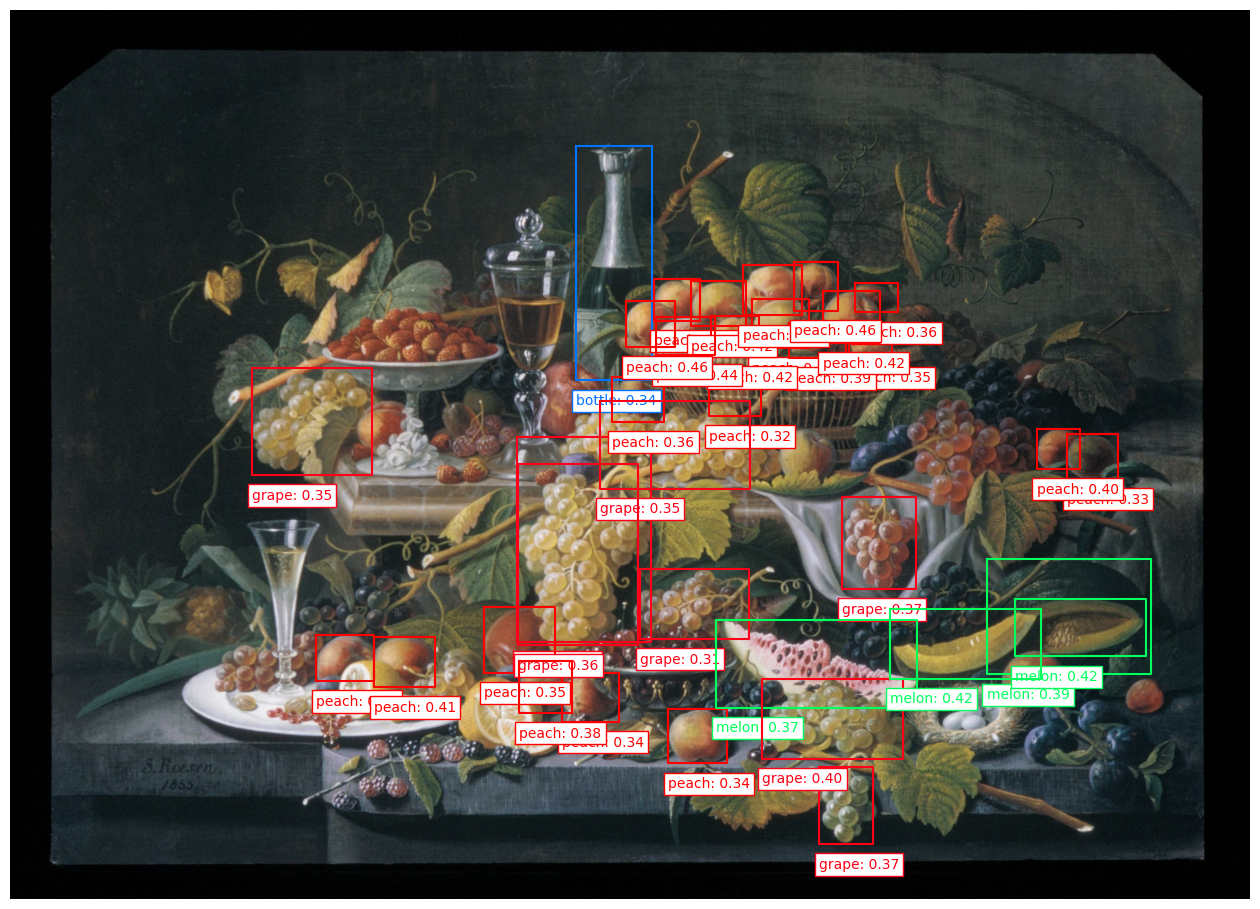

In [ ]:
# @title Predict


def get_text_queries_bytes(text_queries):
    """Returns text queries list as bytes."""
    tensor_array = tf.convert_to_tensor(text_queries)
    tensor_byte_string = tf.io.serialize_tensor(tensor_array)
    return tensor_byte_string.numpy()


def plot_predictions(
    image, logits, boxes, text_queries, score_threshold=0.1, max_num_boxes=200
):
    """Plots the predicted bounding boxes and labels on the given image."""
    colors = plt.cm.hsv(np.linspace(0.0, 1.0, len(text_queries)))
    logits = logits[..., : len(text_queries)]  # Remove padding.
    scores = tf.nn.sigmoid(np.max(logits, axis=-1)).numpy()
    labels = np.argmax(logits, axis=-1)

    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.imshow(image, extent=(0, 1, 1, 0))
    ax.set_aspect(image.shape[0] / image.shape[1])
    ax.set_axis_off()

    num_boxes = 0
    for score, box, label in zip(scores, boxes, labels):
        color = colors[label % 10]
        if score < score_threshold:
            continue
        if num_boxes >= max_num_boxes:
            break
        num_boxes += 1

        y0, x0, y1, x1 = box
        cx, cy, w, h = (x0 + x1) / 2, (y0 + y1) / 2, x1 - x0, y1 - y0
        ax.plot(
            [cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
            [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2],
            color=color,
            zorder=10 + score,
        )
        ax.text(
            cx - w / 2,
            cy + h / 2 + 0.015,
            f"{text_queries[label]}: {score:1.2f}",
            ha="left",
            va="top",
            color=color,
            zorder=10 + score,
            bbox={
                "facecolor": "white",
                "edgecolor": color,
                "boxstyle": "square,pad=.3",
            },
        )


# Local path to the prediction image.
DEMO_IMAGE_PATH = "./prediction_image.jpg"  # @param {type:"string"}
INPUT_IMAGE_PATH = "https://upload.wikimedia.org/wikipedia/commons/c/cd/Still_Life-_Fruit_MET_APS628.jpg"  # @param {type:"string"}
# Download the prediction image.
! wget -O {DEMO_IMAGE_PATH} {INPUT_IMAGE_PATH}

TEXT_QUERIES = ["peach", "glass", "melon", "bottle", "egg", "grape"]

image_bytes = common_util.get_jpeg_bytes(DEMO_IMAGE_PATH)
text_queries_bytes_inputs = get_text_queries_bytes(TEXT_QUERIES)

instances_list = [
    {
        "image_jpeg_bytes_inputs": {
            "b64": base64.b64encode(image_bytes).decode("utf-8")
        },
        "text_queries_bytes_inputs": {
            "b64": base64.b64encode(text_queries_bytes_inputs).decode("utf-8")
        },
    }
]
instances = [json_format.ParseDict(s, Value()) for s in instances_list]
predictions = endpoints["jax_owl2_endpoint"].predict(instances=instances).predictions[0]

plot_predictions(
    image=tf.image.decode_image(image_bytes).numpy(),
    logits=np.asarray(predictions["instance_logits_image"]),
    boxes=np.asarray(predictions["predicted_boxes"]),
    text_queries=TEXT_QUERIES,
    score_threshold=0.3,
)

# @markdown Click "Show Code" to see more details.

## Clean up resources

In [ ]:
# @title Delete the models and endpoints
# @markdown  Delete the experiment models and endpoints to recycle the resources
# @markdown  and avoid unnecessary continuous charges that may incur.

# Undeploy model and delete endpoint.
for endpoint in endpoints.values():
    endpoint.delete(force=True)

# Delete models.
for model in models.values():
    model.delete()

delete_bucket = False  # @param {type:"boolean"}
if delete_bucket:
    ! gsutil -m rm -r $BUCKET_NAME